In [2]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from src import main, plotting, analysis, io_utils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
df = main.main()

c:\Users\maria\anaconda3\envs\bayes\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


7982
8040
8052
8056
8088
8122
8130
8171
8226
8404
8552
8589
8628
8649
8699
8851
8968
9063
9139
9308
9368
9396
9417
9574
9660
9678
9710
9884
10130
10137
10311
10391
10971
10987
11007
total ARs = 108


In [4]:
DFx2=df.assign(frac=lambda x: x.alpha-x.alphab)
DFx2=DFx2.assign(t_mean=lambda x: round(10*x.t_norm)/10)

# SOME PLOTS

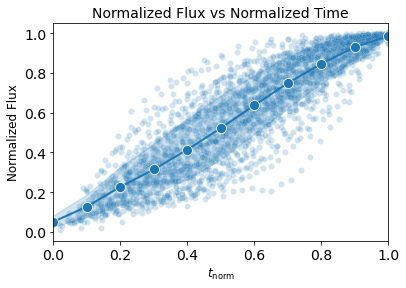

In [17]:
f,ax=plotting.plot_single(DFx2,'fint',title='Normalized Flux vs Normalized Time',scatter=True)
ax.set_ylabel('Normalized Flux')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_xlim(0,1)
ax.legend().remove()
f.savefig('../figures/flux-all.pdf',dpi=300)

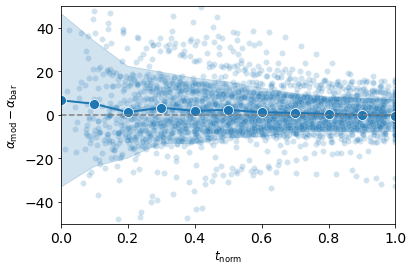

In [18]:
f,ax=plotting.plot_single(DFx2,'frac',title='',scatter=True)
ax.set_ylabel(r'$\alpha_\mathrm{mod} - \alpha_\mathrm{bar}$')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_xlim(0,1)
ax.set_ylim(-50,50)
ax.axhline(0,color='gray',ls='--')
ax.legend().remove()
f.savefig('../figures/alpha-err.pdf',dpi=300)

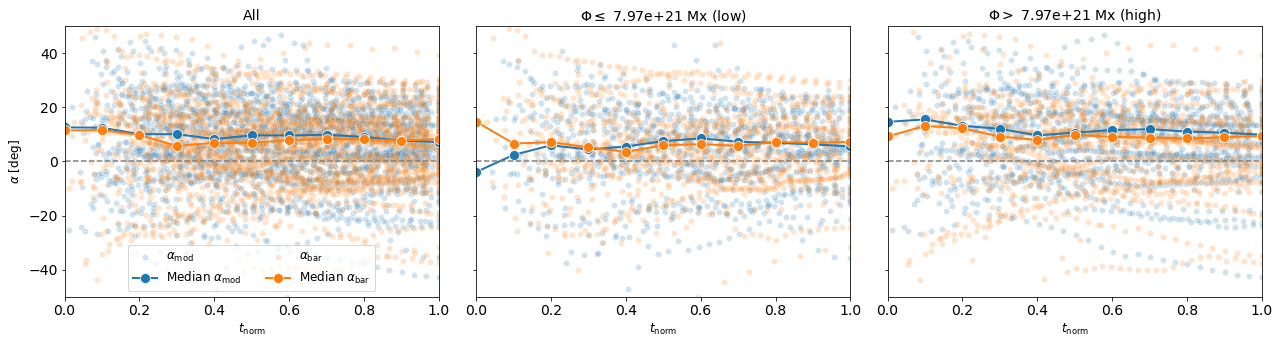

In [14]:
f,ax=plt.subplots(1,3,figsize=(18,5),sharey=True)



db=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index()

arslowf=db[db.flux <= db.flux.median()].AR.unique()
arshighf=db[db.flux > db.flux.median()].AR.unique()


for db1,ax1,title in zip([DFx2,DFx2[DFx2.AR.isin(arslowf)],DFx2[DFx2.AR.isin(arshighf)]],ax,
                        ['All',rf'$\Phi \leq $ {db.flux.median():.2e} Mx (low)',rf'$\Phi > $ {db.flux.median():.2e} Mx (high)']):


    f,ax2=plotting.plot_single(db1,'alpha',title='',ax=ax1,fig=f,scatter=True,estim='median',
                               error=None,err_kws={'alpha':1},color='tab:blue',ls='-')
    f,ax2=plotting.plot_single(db1,'alphab',title='',ax=ax1,fig=f,color='tab:orange',scatter=True,
                               estim='median',
                               error=None,err_kws={'alpha':1},ls='-')
    ax1.set_ylabel(r'$\alpha$ [deg]')
    ax1.set_xlabel(r'$t_\mathrm{norm}$')
    ax1.set_title(title)
    ax1.legend().remove()
   # h,l=ax1.get_legend_handles_labels()
   # ax1.legend(fontsize=12)
    ax1.set_xlim(0,1)
    ax1.set_ylim(-50,50)
    ax1.axhline(0,color='gray',ls='--')

h,l=ax[0].get_legend_handles_labels()
ax[0].legend(ncols=2,fontsize=12,handles=h,labels=[r'$\alpha_\mathrm{mod}$',r'Median $\alpha_\mathrm{mod}$',r'$\alpha_\mathrm{bar}$',r'Median $\alpha_\mathrm{bar}$'],loc='lower center')

f.tight_layout()
f.savefig('../figures/alpha-vs-t_norm.pdf',dpi=300)

In [15]:
h

[]

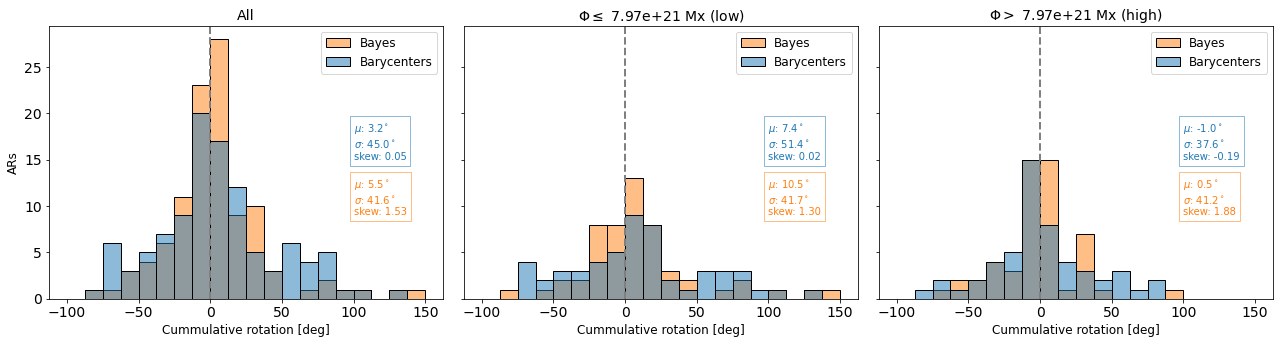

In [15]:
f,ax=plt.subplots(1,3,figsize=(18,5),sharey=True)



db=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index()

arslowf=db[db.flux <= db.flux.median()].AR.unique()
arshighf=db[db.flux > db.flux.median()].AR.unique()


for db1,ax1,title in zip([db,db[db.AR.isin(arslowf)],db[db.AR.isin(arshighf)]],ax,
                        ['All',rf'$\Phi \leq $ {db.flux.median():.2e} Mx (low)',rf'$\Phi > $ {db.flux.median():.2e} Mx (high)']):
    sns.histplot(data=pd.melt(db1,
                            value_vars=['rot_cum','rotb_cum']),x='value',hue='variable',fill=True,ax=ax1,binrange=(-100,150),bins=20)

    ax1.set_xlabel(r'Cummulative rotation [deg]')
    ax1.set_ylabel('ARs')
    ax1.set_title(title)
    

    ax1.legend(title='',labels=['Bayes','Barycenters'],fontsize=12)
    ax1.axvline(0,color='gray',linestyle='--',linewidth=2)

    ax1.text(100,15,f'$\mu$: {db1.rot_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rot_cum.std():.1f}$^\circ$\nskew: {db1.rot_cum.skew():.2f}',
            color='tab:blue',fontsize=10,
            bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='tab:blue'))
    ax1.text(100,9,f'$\mu$: {db1.rotb_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rotb_cum.std():.1f}$^\circ$\nskew: {db1.rotb_cum.skew():.2f}',
            color='tab:orange',fontsize=10,
            bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='tab:orange'))

f.tight_layout()
f.savefig('../figures/hist_cumrot.pdf',dpi=300)

(-2.0, 2.0)

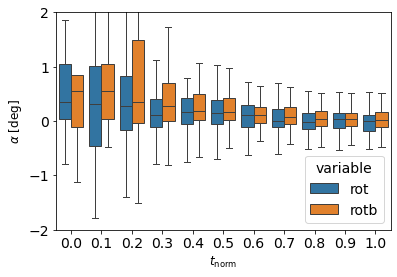

In [8]:
mdf=pd.melt(DFx2,id_vars=['t_norm','t_mean','lat','AR','mag','flux'],value_vars=['rot','rotb'])
dfm=df.groupby('AR').mean().reset_index()

mdf=mdf[(mdf.t_norm>0) & (mdf.t_norm<1.05)]

arsp1=dfm[dfm.rot_cum>0].AR.values
arsp2=dfm[dfm.rotb_cum>0].AR.values
arsn1=dfm[dfm.rot_cum<0].AR.values
arsn2=dfm[dfm.rotb_cum<0].AR.values

# crear máscaras alineadas con el DataFrame completo
mask_pos_rot  = (mdf['variable']=='rot')  & (mdf['AR'].isin(arsp1))
mask_pos_rotb = (mdf['variable']=='rotb') & (mdf['AR'].isin(arsp2))
mdf_pos = mdf[mask_pos_rot | mask_pos_rotb]

mask_neg_rot  = (mdf['variable']=='rot')  & (mdf['AR'].isin(arsn1))
mask_neg_rotb = (mdf['variable']=='rotb') & (mdf['AR'].isin(arsn2))
mdf_neg = mdf[mask_neg_rot | mask_neg_rotb]

f,ax=plt.subplots()
#sns.lineplot(data=mdf,x='t_mean',y='value',estimator='mean',hue='variable',marker='o',errorbar='sd',err_style='bars')
sns.boxplot(data=mdf_pos,x='t_mean',y='value',hue='variable',ax=ax,fliersize=False)
#sns.boxplot(data=mdf_neg,x='t_mean',y='value',hue='variable',ax=ax,fliersize=False)
ax.set_ylabel(r'$\alpha$ [deg]')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_ylim(-2,2)

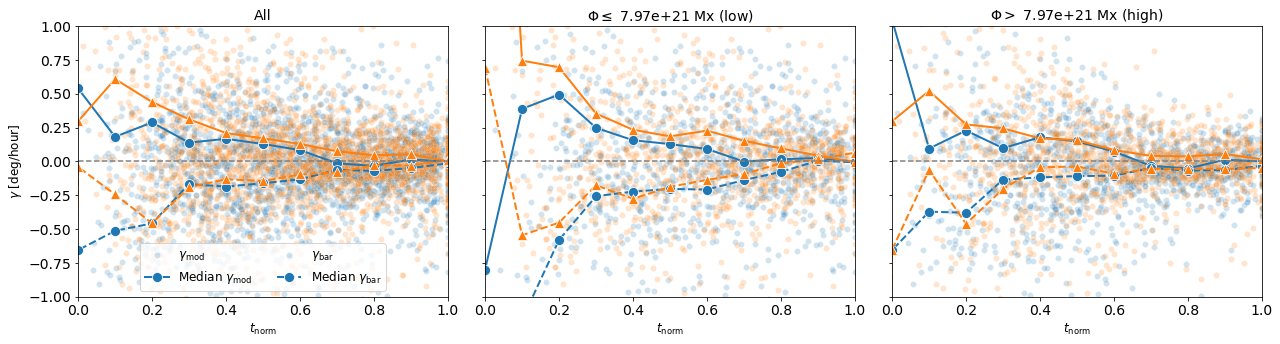

In [ ]:
f,ax=plt.subplots(1,3,figsize=(18,5),sharey=True)



db=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index()

arslowf=db[db.flux <= db.flux.median()].AR.unique()
arshighf=db[db.flux > db.flux.median()].AR.unique()


for db1,ax1,title in zip([DFx2,DFx2[DFx2.AR.isin(arslowf)],DFx2[DFx2.AR.isin(arshighf)]],ax,
                        ['All',rf'$\Phi \leq $ {db.flux.median():.2e} Mx (low)',rf'$\Phi > $ {db.flux.median():.2e} Mx (high)']):

    dfm=db1.groupby('AR').mean().reset_index()

    arsp=dfm[dfm.rot_cum>0].AR.values
    arsn=dfm[dfm.rot_cum<0].AR.values

    # plot rot_cum in blue with circle marker and solid line
    f1,ax1=plotting.plot_single(db1[db1.AR.isin(arsp)],'rot',title='',marker='o',
                            color='tab:blue',error=None,estim='median',
                            err_kws={'alpha':1},ax=ax1,fig=f,scatter=True)


    # plot rot_cum in blue with circle marker and solid line
    f1,ax1=plotting.plot_single(db1[db1.AR.isin(arsn)],'rot',title='',marker='o'
                            ,color='tab:blue',error=None,estim='median',
                            err_kws={'alpha':1},ax=ax1,fig=f,scatter=True,ls='--')

    arsp=dfm[dfm.rotb_cum>0].AR.values
    arsn=dfm[dfm.rotb_cum<0].AR.values

    # plot rotb_cum in orange with triangle marker and dashed line
    f1,ax1=plotting.plot_single(db1[db1.AR.isin(arsp)],'rotb',title='',
                            ax=ax1,fig=f,marker='^',color='tab:orange',estim='median'
                            ,error=None,err_kws={'alpha':1},scatter=True)



    f1,ax1=plotting.plot_single(db1[db1.AR.isin(arsn)],'rotb',title='',
                            ax=ax1,fig=f,marker='^',color='tab:orange',estim='median',
                            error=None,err_kws={'alpha':1},scatter=True,ls='--')

    ax1.legend().remove()
    ax1.set_ylabel(r'$\gamma$ [deg/hour]')
    ax1.set_xlabel(r'$t_\mathrm{norm}$')
    ax1.set_xlim(0,1)
    ax1.set_ylim(-1,1)
    ax1.axhline(0,color='gray',ls='--')
    ax1.set_title(title)

h,l=ax[0].get_legend_handles_labels()
ax[0].legend(ncols=2,fontsize=12,handles=h,
             labels=[r'$\gamma_\mathrm{mod}$',r'Median $\gamma_\mathrm{mod}$',r'$\gamma_\mathrm{bar}$',r'Median $\gamma_\mathrm{bar}$'],
             loc='lower center')
f.tight_layout()
f.savefig('../figures/rot-tilt-by-flux.pdf',dpi=300)

'^'

: 

: 

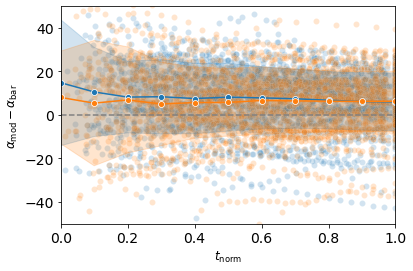

: 

: 

In [ ]:
f,ax=plotting.plot_comparison(DFx2,'alpha','alphab',title='',all=True)
ax.set_ylabel(r'$\alpha_\mathrm{mod} - \alpha_\mathrm{bar}$')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_xlim(0,1)
ax.set_ylim(-50,50)
ax.axhline(0,color='gray',ls='--')

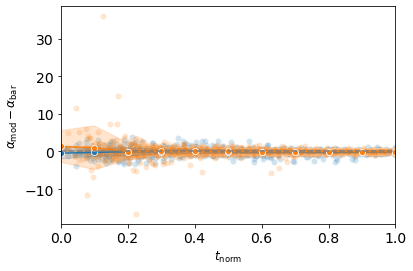

: 

: 

In [ ]:
f,ax=plotting.plot_comparison(DFx2,'rot','rotb',title='',all=True)
ax.set_ylabel(r'$\alpha_\mathrm{mod} - \alpha_\mathrm{bar}$')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_xlim(0,1)
#ax.set_ylim(-50,50)
ax.axhline(0,color='gray',ls='--')